# Running a Recipe Locally
Welcome to the Pangeo Forge introduction tutorial! This is the 2nd part in a sequence, the flow of which is described {doc}`here </introduction_tutorial/index>`.


## Code from Part 1
You'll need the `FilePattern` that was created in Part 1 to work on Part 2.  The Part 1 code is copied here.

In [1]:
import pandas as pd

from pangeo_forge_recipes.patterns import ConcatDim, FilePattern, prune_pattern

dates = pd.date_range('1981-09-01', '2022-02-01', freq='D')

URL_FORMAT = (
    "https://www.ncei.noaa.gov/data/sea-surface-temperature-optimum-interpolation/"
    "v2.1/access/avhrr/{time:%Y%m}/oisst-avhrr-v02r01.{time:%Y%m%d}.nc"
)

def make_url(time):
    return URL_FORMAT.format(time=time)

time_concat_dim = ConcatDim("time", dates, nitems_per_file=1)
pattern = FilePattern(make_url, time_concat_dim)

## Part 2 Outline

The main goal of the first two parts of this tutorial are to create and run a **recipe**, the object that defines our data transformation.
A recipe is an Apache Beam [Composite Transform](https://beam.apache.org/documentation/programming-guide/#composite-transforms).

In part 2 of this tutorial we wil be using the `FilePattern` we defined in Part 1 to create a recipe and use it to create some cloud optimized data on our own computer!

The steps to doing this are:
1. Prune the FilePattern
1. Chain together the necessary beam transforms into a recipe
1. Run the recipe as a Beam Pipeline
1. Check output data


## Prune the File Pattern


Currently our recipe is set up to convert over 3 decades worth of data. That is much more data than we need to run a test (and probably more data than fits on our computer). What we want instead is to run a subset of the data, just to make sure the recipe is working. 

Pangeo Forge has a built in function for getting a smaller test-appropriate file pattern:

In [2]:
pattern_pruned = prune_pattern(pattern)
pattern_pruned

<FilePattern {'time': 2}>

## Create the Recipe object (Beam Composite Transform)

In [3]:
import apache_beam as beam
from pangeo_forge_recipes.transforms import OpenURLWithFSSpec, OpenWithXarray, StoreToZarr

A place for our data to go

In [4]:
from tempfile import TemporaryDirectory
td = TemporaryDirectory()
target_path = td.name + "/output.zarr"
target_path

'/var/folders/kl/7rfdrpx96bb0rhbnl5l2dnkw0000gn/T/tmpy6h7cm84/output.zarr'

In [5]:
transforms = (
    beam.Create(pattern_pruned.items())
    | OpenURLWithFSSpec()
    | OpenWithXarray(file_type=pattern_pruned.file_type)
    | StoreToZarr(
        target_url=target_path,
        combine_dims=pattern.combine_dim_keys,
    )
)
transforms

<_ChainedPTransform(PTransform) label=[Create|OpenURLWithFSSpec|OpenWithXarray|StoreToZarr] at 0x14ee0f070>

## Run the Recipe

In [6]:
with beam.Pipeline() as p:
    p | transforms

## Check output

Now that the process has run we can use `xarray` to inspect the output data.

In [7]:
import xarray as xr

In [8]:
oisst_zarr = xr.open_dataset(target_path, engine="zarr")
oisst_zarr

<xarray.Dataset>
Dimensions:  (time: 2, zlev: 1, lat: 720, lon: 1440)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * time     (time) datetime64[ns] 1981-09-01 1981-09-02
  * zlev     (zlev) float32 0.0
Data variables:
    anom     (time, zlev, lat, lon) float32 ...
    err      (time, zlev, lat, lon) float32 ...
    ice      (time, zlev, lat, lon) float32 ...
    sst      (time, zlev, lat, lon) float32 ...
Attributes: (12/34)
    Conventions:                CF-1.6, ACDD-1.3
    cdm_data_type:              Grid
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    creator_email:              oisst-help@noaa.gov
    creator_url:                https://www.ncei.noaa.gov/
    date_created:               2020-05-08T19:05:13Z
    ...                         ...
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...
    sensor:                     Thermometer, AVHRR
    source:                     ICOADS, NCEP_GTS, GSFC_ICE, NCEP_ICE, Pathfin...
    standard_name_vocabulary:   CF Standard Name Table (v40, 25 January 2017)
    summary:                    NOAAs 1/4-degree Daily Optimum Interpolation ...
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...

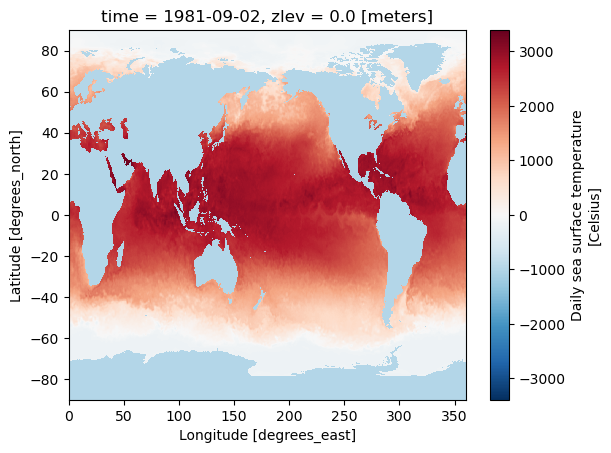

In [9]:
oisst_zarr['sst'].sel(time='1981-09-02').plot()

There it is! Some zarr data that we created during this tutorial! We have converted the netCDF OISST data to zarr and opened it up in xarray. We have a working local recipe.

If we wanted to run the recipe on the full dataset (as opposed to the much smaller pruned version), we would just repeat the above steps on recipe rather than recipe_pruned. This would take a long time, but it would work.